In [1]:
import numpy as np 
import math
import os 
import sys 
import random
import pandas as pd
from tqdm import tqdm
import copy

from bbcpy.datatypes.utils import *
from bbcpy.load.srm_eeg import *
module_path = os.path.abspath(os.path.join('../../bbcpy_AutoML/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils.visualization as vis
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [2]:
srm_metadata_path = "../data/SMR/metadata/"
subject_group_path = list_all_files(srm_metadata_path, pattern="*.json")

In [3]:
subject_group_path["S10"]["Session_1"]

{'S10': {'Session_1': WindowsPath('../data/SMR/metadata/S10_Session_1.json'),
  'Session_10': WindowsPath('../data/SMR/metadata/S10_Session_10.json'),
  'Session_11': WindowsPath('../data/SMR/metadata/S10_Session_11.json'),
  'Session_2': WindowsPath('../data/SMR/metadata/S10_Session_2.json'),
  'Session_3': WindowsPath('../data/SMR/metadata/S10_Session_3.json'),
  'Session_4': WindowsPath('../data/SMR/metadata/S10_Session_4.json'),
  'Session_5': WindowsPath('../data/SMR/metadata/S10_Session_5.json'),
  'Session_6': WindowsPath('../data/SMR/metadata/S10_Session_6.json'),
  'Session_7': WindowsPath('../data/SMR/metadata/S10_Session_7.json'),
  'Session_8': WindowsPath('../data/SMR/metadata/S10_Session_8.json'),
  'Session_9': WindowsPath('../data/SMR/metadata/S10_Session_9.json')},
 'S11': {'Session_1': WindowsPath('../data/SMR/metadata/S11_Session_1.json'),
  'Session_10': WindowsPath('../data/SMR/metadata/S11_Session_10.json'),
  'Session_11': WindowsPath('../data/SMR/metadata/S11_Se

In [ ]:
def get_trial_stats(subject_group_path, key="subject_result"):
    """ Get the trial stats from the trial_info_dict."""
    trial_stat_dict = {}
    sessions_ids = []
    subject_ids = []
    num_subjects = len(subject_group_path.keys())
    if key == "subject_result":
        trial_stat_dict["targethitnumber"] = {}
        trial_stat_dict["targethitnumber"]["L"] = [[] for _ in range(num_subjects)]
        trial_stat_dict["targethitnumber"]["R"] = [[] for _ in range(num_subjects)]
        trial_stat_dict["targethitnumber"]["count"] = {"L": [], "R": []}

        trial_stat_dict["result"] = {}
        trial_stat_dict["result"]["failed"] = [[] for _ in range(num_subjects)]
        trial_stat_dict["result"]["succeed"] = [[] for _ in range(num_subjects)]
        trial_stat_dict["result"]["NT"] = [[] for _ in range(num_subjects)]
        trial_stat_dict["result"]["count"] = {"failed": [], "succeed": [], "NT": []}

        trial_stat_dict["artifact"] = {}
        trial_stat_dict["artifact"]["yes"] = [[] for _ in range(num_subjects)]
        trial_stat_dict["artifact"]["no"] = [[] for _ in range(num_subjects)]
        trial_stat_dict["artifact"]["count"] = {"yes": [], "no": []}

    sorted_subject_group_path = sorted(subject_group_path.keys(), key=lambda x: int(x[1:]))

    for i, subject_id in enumerate(sorted_subject_group_path):
        subject_ids.append(subject_id)

        for session_id, sess_path in subject_group_path[subject_id].items():
            tmp = load_session_metadata(sess_path)
            sess_id = session_id.split("_")[-1]
            sessions_ids.append(f"{subject_id}-{sess_id}")
            if key == "subject_result":
                trial_stat_dict["targethitnumber"]["L"][i].append(tmp["targethitnumber"]["L"])
                trial_stat_dict["targethitnumber"]["R"][i].append(tmp["targethitnumber"]["R"])

                trial_stat_dict["result"]["failed"][i].append(tmp["result"]["failed"])
                trial_stat_dict["result"]["succeed"][i].append(tmp["result"]["succeed"])
                trial_stat_dict["result"]["NT"][i].append(tmp["result"]["NT"])

                # artifact trials
                arti_dict = tmp["artifact"]
                if "yes" in arti_dict:
                    trial_stat_dict["artifact"]["yes"][i].append(arti_dict["yes"])
                else:
                    trial_stat_dict["artifact"]["yes"][i].append(0)
                trial_stat_dict["artifact"]["no"][i].append(arti_dict["no"])

        trial_stat_dict["targethitnumber"]["count"]["L"].append(
            np.sum(np.array(trial_stat_dict["targethitnumber"]["L"][i])))
        trial_stat_dict["targethitnumber"]["count"]["R"].append(
            np.sum(np.array(trial_stat_dict["targethitnumber"]["R"][i])))

        trial_stat_dict["result"]["count"]["failed"].append(np.sum(np.array(trial_stat_dict["result"]["failed"][i])))
        trial_stat_dict["result"]["count"]["succeed"].append(np.sum(np.array(trial_stat_dict["result"]["succeed"][i])))
        trial_stat_dict["result"]["count"]["NT"].append(np.sum(np.array(trial_stat_dict["result"]["NT"][i])))

        trial_stat_dict["artifact"]["count"]["yes"].append(np.sum(np.array(trial_stat_dict["artifact"]["yes"][i])))
        trial_stat_dict["artifact"]["count"]["no"].append(np.sum(np.array(trial_stat_dict["artifact"]["no"][i])))

    trial_stat_dict["subject_ids"] = subject_ids
    trial_stat_dict["sessions_ids"] = sessions_ids

    return trial_stat_dict

In [14]:
stats = load_session_metadata(subject_group_path["S10"]["Session_1"])

In [15]:
stats

{'S10': {'MBSRsubject': False,
  'meditationpractice': nan,
  'handedness': 'R',
  'instrument': 'N',
  'athlete': 'N',
  'handsport': 'N',
  'hobby': 'N',
  'gender': 'F',
  'age': 53.0,
  'date': 20170913.0,
  'day': 3.0,
  'time': 9.0},
 'result': {'failed': 133, 'succeed': 102, 'NT': 215},
 'targetnumber': {'R': 111, 'L': 113, 'U': 114, 'D': 112},
 'targethitnumber': {'R': 44, 'L': 68, 'U': 47, 'D': 76, 'NT': 215},
 'triallength': {'min': 0.52, 'max': 6.04, 'avg': 4.598577777777777},
 'artifact': {'no': 445, 'yes': 5}}

In [4]:
pvc_subject_mean = {}
pvc_subject_sessions = {}

for i, subject_id in enumerate(subject_group_path):
    pvc_subject_mean[subject_id] = {}
    pvc_subject_sessions[subject_id] = {}
    tmp_subject = []
    for session_id, sess_path in subject_group_path[subject_id].items():
        
        stats = load_session_metadata(sess_path)
        pvc_session = stats["result"]["succeed"] / (stats["result"]["succeed"] + stats["result"]["failed"])
        tmp_subject.append(pvc_session)
        pvc_subject_sessions[subject_id][session_id] = pvc_session
        pvc_subject_mean[subject_id] = np.mean(np.array(tmp_subject))


In [5]:
pvc_subject_sessions

{'S10': {'Session_1': 0.4340425531914894,
  'Session_10': 0.49466192170818507,
  'Session_11': 0.513986013986014,
  'Session_2': 0.40370370370370373,
  'Session_3': 0.4807017543859649,
  'Session_4': 0.5186440677966102,
  'Session_5': 0.4606741573033708,
  'Session_6': 0.5292096219931272,
  'Session_7': 0.5680933852140078,
  'Session_8': 0.4782608695652174,
  'Session_9': 0.503731343283582},
 'S11': {'Session_1': 0.6933797909407665,
  'Session_10': 0.7028423772609819,
  'Session_11': 0.6771653543307087,
  'Session_2': 0.7305555555555555,
  'Session_3': 0.7047872340425532,
  'Session_4': 0.6555555555555556,
  'Session_5': 0.6666666666666666,
  'Session_6': 0.6624685138539043,
  'Session_7': 0.7333333333333333,
  'Session_8': 0.6650246305418719,
  'Session_9': 0.6157894736842106},
 'S12': {'Session_1': 0.4281524926686217,
  'Session_10': 0.46578947368421053,
  'Session_11': 0.5065616797900262,
  'Session_2': 0.676923076923077,
  'Session_3': 0.5871313672922251,
  'Session_4': 0.671717171

In [6]:
pvc_subject_mean

{'S10': 0.4896099447392066,
 'S11': 0.6825062259787371,
 'S12': 0.5509085658702036,
 'S14': 0.701502219559637,
 'S15': 0.6283919607773204,
 'S16': 0.5020601095027538,
 'S17': 0.5713271099442906,
 'S19': 0.6013966034979021,
 'S1': 0.684386471499049,
 'S21': 0.4603463192646136,
 'S22': 0.4502707886568623,
 'S23': 0.756871183831494,
 'S25': 0.5887858706117491,
 'S26': 0.7203925046359209,
 'S27': 0.4611912180655768,
 'S28': 0.7627186505990717,
 'S29': 0.7219432284543464,
 'S30': 0.7863405968351519,
 'S32': 0.5774977298993775,
 'S34': 0.5372897881040006,
 'S35': 0.651754547703355,
 'S36': 0.7664275167285645,
 'S37': 0.6523644726644191,
 'S39': 0.8014100277153869,
 'S3': 0.5115544789469554,
 'S41': 0.6770678289471594,
 'S42': 0.6264241320028742,
 'S43': 0.6433533387727383,
 'S44': 0.7074432977995044,
 'S45': 0.6721986347024365,
 'S46': 0.7458193778716791,
 'S47': 0.4589845665351868,
 'S48': 0.4651583062307654,
 'S49': 0.7736055570361001,
 'S4': 0.7481707358262175,
 'S51': 0.7774155022814664,

In [26]:
C1_list = list(sorted_category_3.keys())

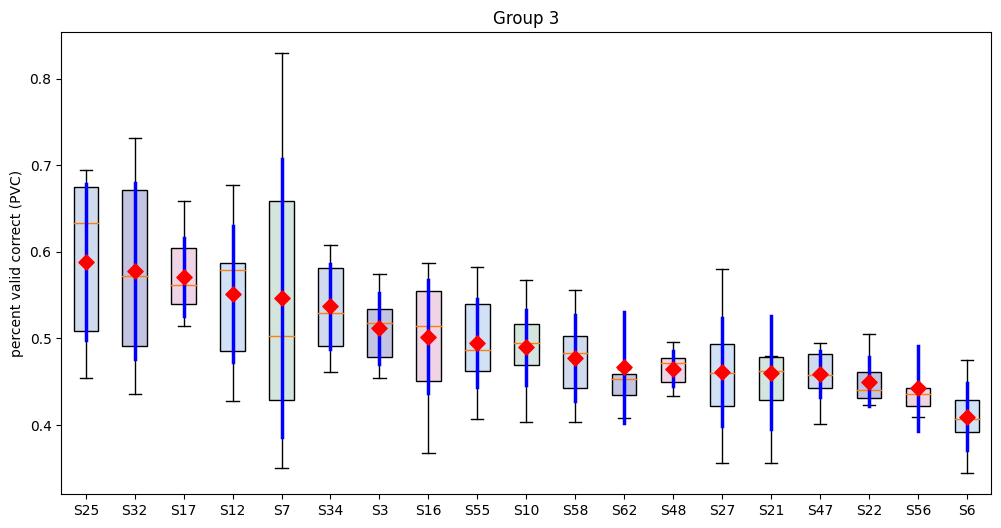

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Sample nested dictionary
data = {key: pvc_subject_sessions[key] for key in C1_list if key in pvc_subject_sessions}

# Extract values for each subject
all_values = [list(subject_data.values()) for subject_data in data.values()]

# Calculate means and standard deviations
means = [np.mean(values) for values in all_values]
std_devs = [np.std(values) for values in all_values]

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bp = ax.boxplot(all_values, vert=True, patch_artist=True, showfliers=False)
ax.set_xticklabels(data.keys())
ax.set_ylabel('percent valid correct (PVC)')
ax.set_title('Group 3')

# Coloring boxes
colors = ['#D0DBEE', '#C2C4E2', '#EED4E5', '#D1E2F7', '#D4E5DE'] * (len(all_values) // 5 + 1)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Plot means as red diamonds
ax.scatter(range(1, len(means) + 1), means, marker='D', color='red', s=60, zorder=5)

# Display standard deviations
for i, (mean, std_dev) in enumerate(zip(means, std_devs), start=1):
    ax.plot([i, i], [mean - std_dev, mean + std_dev], color='blue', lw=2.5, zorder=4)

plt.show()

In [7]:
# Sorting the data into the three categories
category_1 = {k: v for k, v in pvc_subject_mean.items() if v > 0.7}
category_2 = {k: v for k, v in pvc_subject_mean.items() if 0.6 <= v <= 0.7}
category_3 = {k: v for k, v in pvc_subject_mean.items() if v < 0.6}

In [8]:
# Sorting each category by their values
sorted_category_1 = dict(sorted(category_1.items(), key=lambda item: item[1], reverse=True))
sorted_category_2 = dict(sorted(category_2.items(), key=lambda item: item[1], reverse=True))
sorted_category_3 = dict(sorted(category_3.items(), key=lambda item: item[1], reverse=True))

In [22]:
sorted_category_1

{'S57': 0.816520967877968,
 'S39': 0.8014100277153869,
 'S9': 0.7978330213564303,
 'S30': 0.7863405968351519,
 'S52': 0.7819894891488912,
 'S51': 0.7774155022814664,
 'S49': 0.7736055570361001,
 'S36': 0.7664275167285645,
 'S28': 0.7627186505990717,
 'S5': 0.7602303950086287,
 'S23': 0.756871183831494,
 'S4': 0.7481707358262175,
 'S46': 0.7458193778716791,
 'S59': 0.7316546870580262,
 'S29': 0.7219432284543464,
 'S26': 0.7203925046359209,
 'S44': 0.7074432977995044,
 'S14': 0.701502219559637}

In [10]:
sorted_category_2

{'S1': 0.684386471499049,
 'S11': 0.6825062259787371,
 'S41': 0.6770678289471594,
 'S45': 0.6721986347024365,
 'S53': 0.6546178502430191,
 'S37': 0.6523644726644191,
 'S35': 0.651754547703355,
 'S43': 0.6433533387727383,
 'S54': 0.6385507062025416,
 'S15': 0.6283919607773204,
 'S42': 0.6264241320028742,
 'S19': 0.6013966034979021}

In [11]:
sorted_category_3

{'S25': 0.5887858706117491,
 'S32': 0.5774977298993775,
 'S17': 0.5713271099442906,
 'S12': 0.5509085658702036,
 'S7': 0.546979830110719,
 'S34': 0.5372897881040006,
 'S3': 0.5115544789469554,
 'S16': 0.5020601095027538,
 'S55': 0.4951594376813958,
 'S10': 0.4896099447392066,
 'S58': 0.4779017804780852,
 'S62': 0.46654158985493605,
 'S48': 0.4651583062307654,
 'S27': 0.4611912180655768,
 'S21': 0.4603463192646136,
 'S47': 0.4589845665351868,
 'S22': 0.4502707886568623,
 'S56': 0.4424316494820986,
 'S6': 0.4097247800138127}

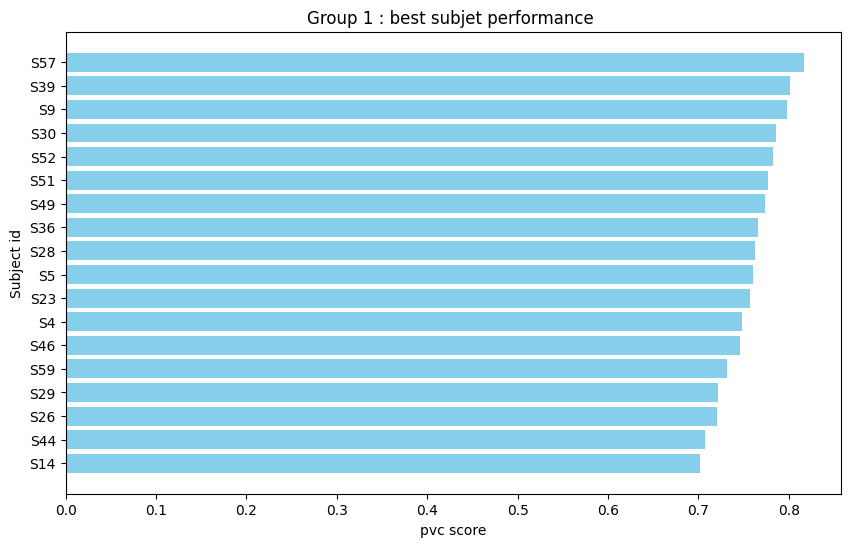

In [13]:
import matplotlib.pyplot as plt
# Daten für die Visualisierung vorbereiten
keys = list(sorted_category_1.keys())
values = list(sorted_category_1.values())

# Das Balkendiagramm erstellen
plt.figure(figsize=(10, 6))
plt.barh(keys, values, color='skyblue')
plt.xlabel('pvc score')
plt.ylabel('Subject id')
plt.title('Group 1 : best subjet performance ')
plt.gca().invert_yaxis()  # Sortiert die Balken von oben nach unten basierend auf den Werten
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# Daten für die Visualisierung vorbereiten
keys = list(sorted_category_2.keys())
values = list(sorted_category_2.values())

# Das Balkendiagramm erstellen
plt.figure(figsize=(10, 6))
plt.barh(keys, values, color='skyblue')
plt.xlabel('pvc score')
plt.ylabel('Subject id')
plt.title('Group 2 : best subjet performance ')
plt.gca().invert_yaxis()  # Sortiert die Balken von oben nach unten basierend auf den Werten
plt.show()